(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
Epoch 1/300 (relu) ===> loss: 0.3880 - train_acc: 0.7417 - test_acc: 0.7074
Epoch 2/300 (relu) ===> loss: 0.4729 - train_acc: 0.7685 - test_acc: 0.7324
Epoch 3/300 (relu) ===> loss: 0.7579 - train_acc: 0.7713 - test_acc: 0.7241
Epoch 4/300 (relu) ===> loss: 0.5985 - train_acc: 0.7917 - test_acc: 0.7352
Epoch 5/300 (relu) ===> loss: 0.5579 - train_acc: 0.8046 - test_acc: 0.7472
Epoch 6/300 (relu) ===> loss: 0.3041 - train_acc: 0.8222 - test_acc: 0.7528
Epoch 7/300 (relu) ===> loss: 0.3623 - train_acc: 0.8037 - test_acc: 0.7454
Epoch 8/300 (relu) ===> loss: 0.3136 - train_acc: 0.8472 - test_acc: 0.7676
Epoch 9/300 (relu) ===> loss: 0.3591 - train_acc: 0.8630 - test_acc: 0.7907
Epoch 10/300 (relu) ===> loss: 0.2554 - train_acc: 0.8769 - test_acc: 0.8028
Epoch 11/300 (relu) ===> loss: 0.3324 - train_acc: 0.8787 - test_acc: 0.7972
Epoch 12/300 (relu) ===> loss: 0.4151 - train_acc: 0.8778 - test_acc: 0.7926
Epoch 13/300 (relu) ===> loss: 0.

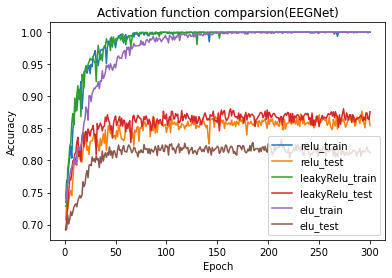

max_acc: 0.8806


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
from argparse import ArgumentParser
from dataloader import read_bci_data

# Define Network
class EEGNet(nn.Module):
    def __init__(self, act_func):
        super(EEGNet, self).__init__()
        self.firstConv = nn.Sequential()
        # [B, 1, 2, 750] -> [B, 16, 2, 750]
        self.firstConv.add_module('conv1', nn.Conv2d(1, 16, (1, 51), 1, (0, 25), bias=False))
        self.firstConv.add_module('norm1', nn.BatchNorm2d(16))

        self.depthwiseConv = nn.Sequential()
        # [B, 16, 2, 750] -> [B, 32, 1, 750]
        self.depthwiseConv.add_module('conv2', nn.Conv2d(16, 32, (2, 1), groups=16, bias=False))
        self.depthwiseConv.add_module('norm2', nn.BatchNorm2d(32))
        self.depthwiseConv.add_module('act1', self.choose_act_func(act_func))
        # [B, 32, 1, 750] -> [B, 32, 1, 187]
        self.depthwiseConv.add_module('pool1', nn.AvgPool2d((1, 4), stride=(1, 4)))
        self.depthwiseConv.add_module('drop1', nn.Dropout(p=0.25))
        
        self.separableConv = nn.Sequential()
        self.separableConv.add_module('conv3', nn.Conv2d(32, 32, (1, 15), padding=(0, 7), bias=False))
        self.separableConv.add_module('norm3', nn.BatchNorm2d(32))
        self.separableConv.add_module('act2', self.choose_act_func(act_func))
        # [B, 32, 1, 187] -> [B, 32, 1, 23]
        self.separableConv.add_module('pool2', nn.AvgPool2d((1, 8), stride=(1, 8)))
        self.separableConv.add_module('drop2', nn.Dropout(p=0.25))

        self.classify = nn.Sequential(
            nn.Linear(32*23, 2)
        )

    def forward(self, x):
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        res = x.view(x.size(0), -1)     # [B, 32, 1, 23] -> [B, 32 * 23]
        out = self.classify(res)
        return out
    
    def choose_act_func(self, act_name='relu'):
      act_func = {
          'relu': nn.ReLU(),
          'leakyRelu': nn.LeakyReLU(),
          'elu': nn.ELU()
      }[act_name]
      return act_func

def cal_accuracy(model, x, y):
    t_x = torch.from_numpy(x.astype(np.float32)).cuda(0)
    gt = torch.from_numpy(y.astype(np.float32)).cuda(0)
    pred_y = model(t_x)
    pred_y = torch.max(pred_y, 1)[1].data.cpu().numpy()
    accuracy = float((pred_y == gt.data.cpu().numpy()).astype(int).sum()) / float(gt.size(0))
    return accuracy

def plot(epochs, acc_dict):
    plt.title('Activation function comparsion(EEGNet)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(range(1, epochs+1), acc_dict['relu_train'])
    plt.plot(range(1, epochs+1), acc_dict['relu_test'])
    plt.plot(range(1, epochs+1), acc_dict['leakyRelu_train'])
    plt.plot(range(1, epochs+1), acc_dict['leakyRelu_test'])
    plt.plot(range(1, epochs+1), acc_dict['elu_train'])
    plt.plot(range(1, epochs+1), acc_dict['elu_test'])
    plt.legend(['relu_train', 'relu_test', 'leakyRelu_train', 'leakyRelu_test', 'elu_train', 'elu_test'], loc='lower right')
    plt.savefig('EEGNet_accuracy.png', dpi=300)
    plt.show()

def main(args):
    # Training settings
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    
    # Dataloader
    train_x, train_y, test_x, test_y = read_bci_data()
    torch_dataset = Data.TensorDataset(torch.from_numpy(train_x.astype(np.float32)), torch.from_numpy(train_y.astype(np.float32)))
    train_loader = Data.DataLoader(dataset=torch_dataset, batch_size=args.batch_size, shuffle=True)
    
    max_acc = 0
    acc_dict = {'relu_train':[], 'leakyRelu_train':[], 'elu_train':[],
                'relu_test':[], 'leakyRelu_test':[], 'elu_test':[]}
    act_funcs = ['relu', 'leakyRelu', 'elu']
    for act_func in act_funcs:
        net = EEGNet(act_func)
        if args.cuda:
            device = torch.device('cuda')
            net = net.to(device)
        Loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)
        
        # Start training
        for epoch in range(args.epochs):
            print("Epoch {}/{} ({})".format(epoch+1, args.epochs, act_func), end=' ===> ')

            # Training
            for data, target in train_loader:
                if args.cuda:
                    data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = net(data)
                loss = Loss(output, target.long())
                loss.backward()
                optimizer.step()

            # Show loss and accuracy
            net.eval()
            train_accuracy = cal_accuracy(net, train_x, train_y)
            test_accuracy = cal_accuracy(net, test_x, test_y)
            if test_accuracy > max_acc:
                max_acc = test_accuracy

            print('loss: {:.4f} - train_acc: {:.4f} - test_acc: {:.4f}'.format(loss, train_accuracy, test_accuracy))
            acc_dict[act_func+'_train'].append(train_accuracy)
            acc_dict[act_func+'_test'].append(test_accuracy)
            net.train()
    
    # Show results
    plot(args.epochs, acc_dict)
    print('max_acc: {:.4f}'.format(max_acc))

def get_args():
    parser = ArgumentParser(description='PyTorch EEGNet')
    parser.add_argument('--batch-size', type=int, default=32, metavar='N')
    parser.add_argument('--epochs', type=int, default=300, metavar='N')
    parser.add_argument('--lr', type=float, default=1e-3, metavar='LR')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M')
    parser.add_argument('--no-cuda', action='store_true', default=False)
    parser.add_argument('--seed', type=int, default=1, metavar='S')

    return parser.parse_args(args=[])

if __name__ == "__main__":
    main(get_args())